In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import random
import time

from tqdm import tqdm
tqdm.pandas()
from sklearn.utils import shuffle
from sklearn.model_selection import KFold,StratifiedKFold
from skimage.transform import resize
import os
import gc
import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

D:\Anaconda\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SequentialSampler
from torch.utils.tensorboard import SummaryWriter
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.__version__

'1.6.0'

In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    
GLOBAL_SEED = 42
setup_seed(GLOBAL_SEED)

In [4]:
data_path = 'D:\\Desktop\\competition\\RFCX\\data'
feat_path = 'D:\\Desktop\\competition\\RFCX\\features'
res_path = 'D:\\Desktop\\competition\\RFCX\\res'
model_path = 'D:\\Desktop\\competition\\RFCX\\model_save'
tensorboard_path = 'D:\\Desktop\\competition\\RFCX\\tensorboard'
if not os.path.exists(model_path):
    os.makedirs(model_path)
if not os.path.exists(res_path):
    os.makedirs(res_path)
if not os.path.exists(tensorboard_path):
    os.makedirs(tensorboard_path)

## EDA

In [5]:
data_tp_df=pd.read_csv(os.path.join(data_path, 'train_tp.csv'))
data_fp_df=pd.read_csv(os.path.join(data_path, 'train_fp.csv'))

- We define functions for display of:
    - Waveplots
    - Spectrograms
    - Mel spectrograms
    - Chroma feature
    - Harmonics and Perceptual sound wave components

In [6]:
def plot_audio_file(data_df, idx):
    audio_file_path = os.path.join(data_path, 'train', data_df.recording_id[idx]+'.flac')
    plt.figure(figsize=(12,6))
    x , sr = librosa.load(audio_file_path)
    librosa.display.waveplot(x, sr=sr)
    plt.gca().set_title(f"Waveplot - file: {data_df.recording_id[idx]}")
    plt.show()

    
def plot_spectrogram(data_df, idx):
    audio_file_path = os.path.join(data_path, 'train', data_df.recording_id[idx]+'.flac')
    plt.figure(figsize=(12,6))
    x , sr = librosa.load(audio_file_path)
    xs = librosa.stft(x)
    xdb = librosa.amplitude_to_db(abs(xs))
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.gca().set_title(f"Spectrogram - file: {data_df.recording_id[idx]}")
    plt.colorbar()

    
def plot_mel_spectrogram(data_df, idx):
    audio_file_path = os.path.join(data_path, 'train', data_df.recording_id[idx]+'.flac')
    plt.figure(figsize=(12,6))
    x , sr = librosa.load(audio_file_path)
    xs = librosa.feature.melspectrogram(x)
    xdb = librosa.power_to_db(abs(xs))
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.gca().set_title(f"Mel spectrogram - file: {data_df.recording_id[idx]}")
    plt.colorbar()
    
def plot_harmonics_and_perceptual(data_df, idx):
    audio_file_path = os.path.join(data_path, 'train', data_df.recording_id[idx]+'.flac')
    plt.figure(figsize=(12,6))
    x , sr = librosa.load(audio_file_path)
    y_harmonics, y_perceptual = librosa.effects.hpss(x)
    plt.plot(y_perceptual, color = '#BBAA12')
    plt.plot(y_harmonics, color = '#12AABB')
    plt.legend(("Perceptual", "Harmonics"))
    plt.title(f"Harmonics and Perceptual - file: {data_df.recording_id[idx]}")
    

def plot_chroma_feature(data_df, idx):
    hop_length=12
    audio_file_path = os.path.join(data_path, 'train', data_df.recording_id[idx]+'.flac')
    plt.figure(figsize=(12,6))
    x , sr = librosa.load(audio_file_path)
    chromagram = librosa.feature.chroma_stft(x)
    librosa.display.specshow(chromagram, sr=sr, x_axis='time', y_axis='chroma',hop_length=hop_length, cmap='coolwarm')
    plt.title(f"Chroma feature - file: {data_df.recording_id[idx]}")

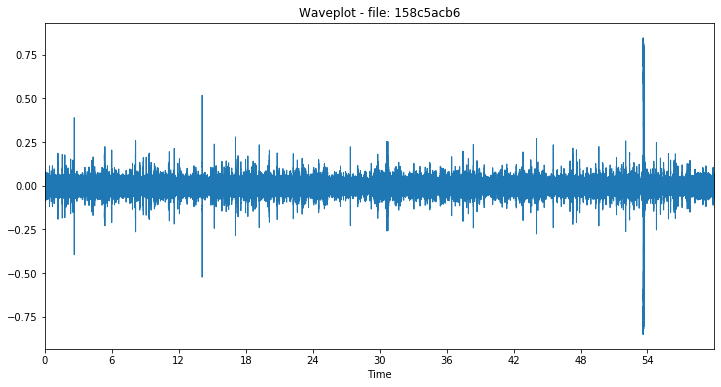

In [ ]:
index = 100
plot_audio_file(data_tp_df, index)
plot_spectrogram(data_tp_df, index)
plot_mel_spectrogram(data_tp_df, index)
plot_harmonics_and_perceptual(data_tp_df, index)
plot_chroma_feature(data_tp_df, index)

## Some Global Parameter

In [ ]:
num_class = 24
fft = 2048
hop = 512
sr = 48000
length = 10 * sr
# Check minimum/maximum frequencies for bird calls
# Not neccesary, but there are usually plenty of noise in low frequencies, and removing it helps
fmin = data_tp_df.f_min.min()
fmax = data_tp_df.f_max.max()

# Get some safety margin
fmin = int(fmin * 0.9)
fmax = int(fmax * 1.1)

## Load Data

In [ ]:
def load_train_data(s):
    # All sound files are 48000 bitrate, no need to slowly resample
    audio_file_path = os.path.join(data_path, 'train', s['recording_id']+'.flac')
    wav, _ = librosa.load(audio_file_path, sr=sr)

    t_min = float(s['t_min']) * sr
    t_max = float(s['t_max']) * sr

    # Positioning sound slice
    center = np.round((t_min + t_max) / 2)
    beginning = center - length / 2
    if beginning < 0:
        beginning = 0

    ending = beginning + length
    if ending > len(wav):
        ending = len(wav)
        beginning = ending - length

    slice = wav[int(beginning):int(ending)]
    return slice

In [ ]:
data_tp_df['data'] = data_tp_df.progress_apply(load_train_data, axis=1)

In [ ]:
data_tp_df.head()

## Prepare Dataset and Dataloader

In [ ]:
"https://www.kaggle.com/gopidurgaprasad/audio-augmentation-albumentations/"

import matplotlib.pyplot as plt
import IPython.display as ipd
import albumentations
from albumentations.core.transforms_interface import DualTransform, BasicTransform
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, PolarityInversion, Gain, AddGaussianSNR


class AudioTransform(BasicTransform):
    """Transform for Audio task"""

    @property
    def targets(self):
        return {"data": self.apply}
    
    def update_params(self, params, **kwargs):
        if hasattr(self, "interpolation"):
            params["interpolation"] = self.interpolation
        if hasattr(self, "fill_value"):
            params["fill_value"] = self.fill_value
        return params
    
      
class MelSpectrogram(AudioTransform):
    """Shifting time axis"""
    def __init__(self, parameters, always_apply=False, p=0.5):
        super(MelSpectrogram, self).__init__(always_apply, p)

        self.parameters = parameters
    
    def apply(self, data, **params):
        sound, sr = data

        melspec = librosa.feature.melspectrogram(sound, sr=sr, **self.parameters)
        melspec = librosa.power_to_db(melspec)
        melspec = melspec.astype(np.float32)

        return melspec, sr
    
    
class SpecAugment(AudioTransform):
    """Shifting time axis"""
    def __init__(self, num_mask=2, freq_masking=0.15, time_masking=0.20, always_apply=False, p=0.5):
        super(SpecAugment, self).__init__(always_apply, p)

        self.num_mask = num_mask
        self.freq_masking = freq_masking
        self.time_masking = time_masking
    
    def apply(self, data, **params):
        melspec, sr = data

        spec_aug = self.spec_augment(melspec, 
                                     self.num_mask,
                                     self.freq_masking,
                                     self.time_masking,
                                     melspec.min())
        

        return spec_aug, sr
    
    # Source: https://www.kaggle.com/davids1992/specaugment-quick-implementation
    def spec_augment(self, 
                    spec: np.ndarray,
                    num_mask=2,
                    freq_masking=0.15,
                    time_masking=0.20,
                    value=0):
        spec = spec.copy()
        num_mask = random.randint(1, num_mask)
        for i in range(num_mask):
            all_freqs_num, all_frames_num  = spec.shape
            freq_percentage = random.uniform(0.0, freq_masking)

            num_freqs_to_mask = int(freq_percentage * all_freqs_num)
            f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
            f0 = int(f0)
            spec[f0:f0 + num_freqs_to_mask, :] = value

            time_percentage = random.uniform(0.0, time_masking)

            num_frames_to_mask = int(time_percentage * all_frames_num)
            t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
            t0 = int(t0)
            spec[:, t0:t0 + num_frames_to_mask] = value

        return spec

    
class SpectToImage(AudioTransform):

    def __init__(self, always_apply=False, p=0.5):
        super(SpectToImage, self).__init__(always_apply, p)
    
    def apply(self, data, **params):
        image, sr = data
        delta = librosa.feature.delta(image)
        accelerate = librosa.feature.delta(image, order=2)
        image = np.stack([image, delta, accelerate], axis=-1)
#         image = image.astype(np.float32) / 100.0

        return image


sound_augment = Compose([
    PolarityInversion(p=0.2),
    Gain(min_gain_in_db=-15, max_gain_in_db=15, p=0.3),
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.2),
    AddGaussianSNR(p=0.2)
#     TimeStretch(min_rate=0.8, max_rate=1.25, p=0.2)
#     Shift(min_fraction=-0.1, max_fraction=0.1, p=0.2),
])


melspectrogram_parameters = {
        "n_mels": 256,
        'n_fft': 2048, 
        'hop_length': 512,
        'fmin': fmin, 
        'fmax': fmax
    }

spec_augment = albumentations.Compose([
    MelSpectrogram(parameters=melspectrogram_parameters, always_apply=True),
    SpecAugment(p=0.2),
    SpectToImage(always_apply=True)
])

to_image = albumentations.Compose([
    MelSpectrogram(parameters=melspectrogram_parameters, always_apply=True),
    SpectToImage(always_apply=True)
])

def augment(wav):
    data = sound_augment(samples=wav, sample_rate=sr), sr
    image = spec_augment(data=data)['data']
    return image.transpose(2, 1, 0)

def get_image(wav):
    data = wav, sr
    image = to_image(data=data)['data']
    return image.transpose(2, 1, 0)

In [ ]:
from torchvision import transforms
class TrainDataset(Dataset):
    def __init__(self, data_df, is_valid=False):
        self.data_df = data_df
        self.is_valid = is_valid
        self.transformer = transforms.Compose([
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, idx):
        s = self.data_df.iloc[idx]
        if self.is_valid:
            img = get_image(s['data'])
        else:
            img = augment(s['data'])
        return torch.tensor(img, dtype=torch.float32), s['species_id']

In [ ]:
batch_size = 16
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=GLOBAL_SEED)
data_folds = []
valid_indexs = []

for idx, (train_index, valid_index) in enumerate(kf.split(X=data_tp_df, y=data_tp_df['species_id'])):
    valid_indexs.append(valid_index)
    
    train_dataset = TrainDataset(data_tp_df.iloc[train_index], is_valid=False)
    val_dataset = TrainDataset(data_tp_df.iloc[valid_index], is_valid=True)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, sampler=SequentialSampler(val_dataset), shuffle=False, num_workers=0)
    data_folds.append((train_dataloader, valid_dataloader))

## Build Model and Train

In [ ]:
from resnest.torch import resnest50
import torchvision

In [ ]:
class ResNest(nn.Module):
    def __init__(self):
        super().__init__()
#         self.model = torchvision.models.densenet161(pretrained=True)
#         self.model.classifier = nn.Linear(2208, num_class)   
        self.model = resnest50(pretrained=True)

        self.model.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.0),
            nn.Linear(1024, num_class)
        )
        
    def forward(self, X):
        return self.model(X)

In [ ]:
def validate(model, val_dataloader, criterion, history, n_iters, fold):
    model.eval()
    costs = []
    accs = []
    with torch.no_grad():
        for idx, batch in enumerate(val_dataloader):
            X, y = batch
            X, y = X.cuda(), y.cuda().float()
            y_output = model(X)    
            loss = criterion(y_output, y)
            costs.append(loss.item())
            _, y_preds = torch.max(y_output, 1)
            accs.append((y_preds == y).float().mean().item())
    mean_accs = np.mean(accs)
    mean_costs = np.mean(costs)
    writer.add_scalar('validate_accuracy', mean_accs, n_iters)
    writer.add_scalar('validate_loss', mean_costs, n_iters)
    if mean_accs > history['best_acc'][fold]:  
        history['best_acc'][fold] = mean_accs
        checkpoint_pth = history['best_model_path'][fold]
        torch.save(model.state_dict(), checkpoint_pth)
    return mean_costs, mean_accs


def train(model, train_dataloader, val_dataloader, criterion, optimizer, epoch, history, validate_points, scheduler, fold, step=True):
    model.train()
    costs = []
    accs = []
    val_loss, val_acc = 0, 0
    with tqdm(total=len(train_dataloader.dataset), desc='Epoch{}'.format(epoch)) as pbar:
        for idx, batch in enumerate(train_dataloader):
            X, y = batch
            X, y = X.cuda(), y.cuda().float()
            y_output = model(X)    
            loss = criterion(y_output, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if step:
                scheduler.step()
            with torch.no_grad():
                costs.append(loss.item())
                _, y_preds = torch.max(y_output, 1)
                accs.append((y_preds == y).float().mean().item())
                pbar.update(y.size(0))
            n_iters = idx + len(train_dataloader) * (epoch-1)
            if idx in validate_points:
                val_loss, val_acc = validate(model, val_dataloader, criterion, history, n_iters, fold)
                model.train()
            writer.add_scalar('train_accuracy', accs[-1], n_iters)
            writer.add_scalar('train_loss', costs[-1], n_iters)
            writer.add_scalar('learning_rate', scheduler.get_lr()[0], n_iters)
            pbar.set_postfix_str('loss:{:.4f}, acc:{:.4f}, val-loss:{:.4f}, val-acc:{:.4f}'.format(np.mean(costs[-10:]), np.mean(accs[-10:]), val_loss, val_acc))
            torch.cuda.empty_cache()
            

In [ ]:
pos_weights = torch.ones(num_class)
counts = data_tp_df['species_id'].value_counts()
for i in range(num_class):
    pos_weights[i] = (sum(counts)-counts[i])/counts[i]
loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

def criterion(y_pred, y_target):
    loss = loss_function(y_pred, F.one_hot(y_target, num_class=num_class))
    return loss

model_name = 'resnest_0'
time_stamp = '{0:%m_%d_%H_%M}'.format(datetime.datetime.now())
history = {
    'best_acc': [0]*len(data_folds), 
    'best_model_path': [os.path.join(model_path, '{}_{}_fold_{}.pth'.format(model_name, time_stamp, i)) for i in range(len(data_folds))]
}
for idx, (train_dataloader, val_dataloader) in enumerate(data_folds):
    
    validate_points = list(np.linspace(0, len(train_dataloader)-1, 2).astype(int))[1:]
    model = ResNest().cuda()
#     model = nn.DataParallel(model, device_ids=[0, 1])
    optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=1e-3)
    epochs = 50
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)
#     scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=2e-3, step_size_up=int(len(train_dataloader)/2), cycle_momentum=False, mode='triangular')
#     scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=3e-3, epochs=epochs, steps_per_epoch=len(train_dataloader), pct_start=0.2, anneal_strategy='linear', div_factor=30, final_div_factor=1e4)
    for epoch in range(1, epochs+1):
        writer = SummaryWriter(log_dir=os.path.join(tensorboard_path, '{}_fold_{}'.format(model_name, idx)))
        train(model, train_dataloader, val_dataloader, criterion, optimizer, epoch, history, validate_points, scheduler,  fold=idx, step=False)
        scheduler.step()
        gc.collect()
    del model 
    gc.collect()
    torch.cuda.empty_cache()
    
    
with open(os.path.join(model_path, '{}_{}_history.pkl'.format(model_name, time_stamp)), 'wb') as f:
    pickle.dump(history, f)

In [131]:
model_path

'D:\\Desktop\\competition\\RFCX\\model_save'

In [129]:
len(data_folds)

5

In [ ]:
with open(os.path.join(model_path, '{}_{}_history.pkl'.format(model_name, time_stamp)), 'rb') as f:
    t = pickle.load(f)

In [ ]:
model.load_state_dict(torch.load(history['best_model_path'], map_location= torch.device('cpu')), strict=True)